# 2値化シミュレーション

## parameters

## ZytleBotアルゴリズム

BGR変換->キャリブレーション->鳥瞰画像化->グレースケール化->適応的閾値2値化->RGB化(デバッグ画像)

Canny法エッジ検出->確率的ハフ変換

真ん中画像，左側画像，真ん中右半分画像

走行距離求める

道路標示が閾値より近ければtrueに変更

- 人形検出時 -> 一定時間停車→発進
- 直進中フェーズ&車線ロスト時間0.5以上&次タイルが十字路 -> 十字路直進フェーズに変更
- 直進フェーズ -> 左車線角度更新，赤色障害物検出，道路標示検出，フェーズ更新，車線維持
- 右カーブ -> 右カーブトレース
- 車線探索 -> 左車線角度測定，車線探索
- 左折 -> 左折
- 右折 -> 右折
- 物体検出 -> 回避
- 十字路直進 -> 直進
- 横断歩道 -> 赤信号なら停車

左側画像->Canny法エッジ検出->確率的ハフ変換HoughLinesP(temp_dst, lines, rho=1, theta=CV_PI / 180, threshold=20, minLineLength=40, maxLineGap=5)->角度が20度以内の線分の角度平均・最も左側の線分の中点座標

通常の鳥瞰画像->関心領域切取->HSV変換->2値化->画素数閾値以上で検出(上限も設定するといいかも)->T字路直進時は次のタイルに移動

広域鳥瞰画像->車体角度*(-0.7)画像を回転->中央左半分画像化->テンプレートマッチ->閾値以上で検出

lineTrace
中点が右->x+=0.01, z=-0.05
中点が左->x+=0.01, z= 0.05
中点が真ん中->x+=0.02

角度が10度以上
z=角度平均*-0.01

車線非検出時
twist.angular.z = (BIRDSEYE_LENGTH * RUN_LINE - detected_line_x) / 600;

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## GUI

In [42]:
from tkinter import *
from tkinter import ttk
import os

class application:
    def __init__(self):
        
        # Windowの作成
        root = Tk()
        root.title("simulate")
        root.geometry("400x300")
        
        # mainframeの作成
        # paddingは隙間
        mainframe = ttk.Frame(root, padding="3 3 12 12")
        # 中央に配置し4方向に引き延ばす
        mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        root.columnconfigure(0, weight=1)
        root.rowconfigure(0, weight=1)

        
        feet = StringVar()
        feet_entry = ttk.Entry(mainframe, width=7, textvariable=feet)
        feet_entry.grid(column=2, row=1, sticky=(W, E))

        self.meters = StringVar()
        self.filepath = StringVar()
        filepath_entry = ttk.Entry(mainframe, width=7, textvariable=self.filepath).grid(column=1, row=3, sticky=(W, E))
        ttk.Label(mainframe, textvariable=self.meters).grid(column=2, row=2, sticky=(W, E))


        
        ttk.Button(mainframe, text="Calculate", command=calculate).grid(column=3, row=3, sticky=W)
        ttk.Button(mainframe, text="ref", command=self.get_filepath).grid(column=2, row=3, sticky=W)

        
        
        ttk.Label(mainframe, text="feet").grid(column=3, row=1, sticky=W)
        ttk.Label(mainframe, text="is equivalent to").grid(column=1, row=2, sticky=E)
        ttk.Label(mainframe, text="meters").grid(column=3, row=2, sticky=W)

        for child in mainframe.winfo_children(): 
            child.grid_configure(padx=5, pady=5)

        feet_entry.focus()
        root.bind("<Return>", calculate)

        root.mainloop()

    def calculate(*args):
        try:
            value = float(feet.get())
            self.meters.set(int(0.3048 * value * 10000.0 + 0.5)/10000.0)
        except ValueError:
            pass

    def get_filepath(self):
        print("tahnks")
        initDir = os.path.abspath(os.path.dirname('__file__'))
        filetype = [("all", "*")]
        self.filepath.set( tk.filedialog.askopenfilename(filetypes=filetype, initialdir=initDir))


    
if __name__ == '__main__':
    application()




tahnks


## 画像入力

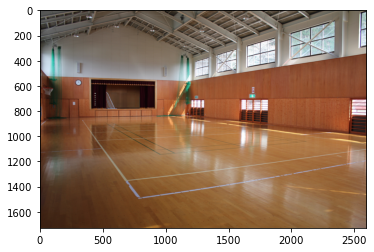

In [18]:
# 画像読み込み(BGR)
#img_path = "./images/barricade_fpt_web_page.jpg"
#img_path = "./images/gym_okayama_univ.jpg"
#img_path = "./images/gym_okayama_univ_2.jpg"
#img_path = "./images/gym3.jpg"
img_path = "./images/gym4.jpg"
img = cv2.imread(img_path)
# 画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
# HSV変換
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# 2値化閾値
red_low_h = 0
red_low_s = 127
red_low_v = 0
red_high_h = 15
red_high_s = 255
red_high_v = 255
# 2値化(マスク画像作成)
lower = (red_low_h, red_low_s, red_low_v)
upper = (red_high_h, red_high_s, red_high_v)
img_binary = cv2.inRange(img, lower, upper)
# BGR変換
img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
# デバッグ画像作成
img[img_binary==0] = (255, 0, 0)

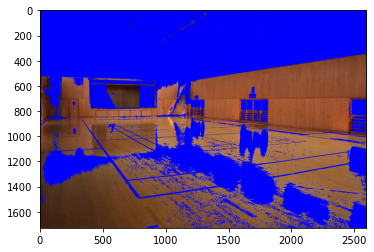

In [20]:
# 画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 画素数による障害物判定
#fractionNum = cv2.countNonZero(img_binary)
#red_detect_num = 200
#if fractionNum > red_detect_num:
    #print("detect object")